# Basic Model: Ambulance + Overdose



## Ambulance Call-outs Model

$n_{A}$: sample size   
$x_{A}$: the total number who confirmed they did call an ambulance  
$p_{A}$: probability of a person call an ambulance   

$$x_{A} \sim Bin(n_{A},p_{A})$$

**We assume $n_{A}=1000, p_A = 0.8$.**  
**Suppose the prior of p is noninformative.** 
$$p(p) \sim Beta(1,1)$$

## Overdose Model
Now we plug in this values into the overdose model and obtain possible $O_t$ values **assuming we have $U_t$ values.**
Also, we have priors.


$$z_{t} \sim N(\mu, \sigma^{2})$$  
$$\lambda_{t}^{OD} = \exp(z_{t})$$  
$$O_{t} \sim Poi(\lambda_{t}^{OD}N)$$  
$$U_t \sim Bin(O_t, p_A)$$  
For simplicity we set N =10000 for now. We need to generate reasonable $U_t$ values first. Note that $U_t$ comes from $\mu, \sigma$ following all the way through the overdose model.  



$\mu=\log0.05, \sigma=1, N=10000$.   
We suppose survey data exists: ($n_A, x_A$) known.  

**We set for our prior parameters:** $$\mu \sim U(-10,0)$$  $$\sigma \sim U(0,5)$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

Below is the function that generate data from simulation.

In [2]:
def sim_ambulance_overdoses(mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, n_a=1000, n_T=12):
    '''
    Simulate ambulance call outs to overdoses and ambulance-call outs survey
    parameters
    -----------
    mu_z- float 
        log rate for lambda
    
    sigma_z -float
        variance of log lambda
    
    N - int
        Total size of population
        
    p_a - float
        probability of calling ambulance at the scene of overdose
    
    n_a - int
        total number of survey
    
    n_T - int
        number of time points  
    '''
    # generate z_t values
    zt = np.random.normal(loc=mu_z, scale = sigma_z, size = n_T)
    
    # convert into lambda_t
    lmd_t = np.exp(zt)
    
    # generate O_t data set
    o_t = np.random.poisson(lmd_t*N)
    
    # generate U_t data set
    u_t = np.random.binomial(n=o_t, p=p_a)
    
    # generate x_t data set
    x_a = np.random.binomial(n=n_a, p=p_a, size=12)
    
    return {'o_t':o_t, 'u_t':u_t, 'x_a':x_a, 'n_a':n_a,'N':N}

In [3]:
data= sim_ambulance_overdoses()

In [4]:
data

{'o_t': array([ 425,  782, 1697,  224,  785,   79,  244,  291,  842,  418,  133,
          40]),
 'u_t': array([ 337,  621, 1332,  180,  630,   64,  194,  230,  654,  346,  116,
          32]),
 'x_a': array([791, 821, 803, 809, 816, 818, 788, 821, 818, 789, 798, 799]),
 'n_a': 1000,
 'N': 10000}

In [5]:
def create_model(data):
    N = data['N']
    
    with pm.Model() as model:
        # priors 
        p_a = pm.Beta('p_a', alpha=1, beta=1)
        # note that this prior is to be changed later
        mu_z = pm.Uniform('mu_z', -10, 0)
        sigma_z = pm.Uniform('sigma_z',0,5)
        
        # latent variables
        z_t = pm.Normal('z_t', mu=mu_z, sigma=sigma_z, shape=(12,))
        lmb_t = pm.Deterministic('lmb_t', tt.exp(z_t))
#       o_t = pm.Poisson('o_t', lmb_t*N)
        o_t = pm.Gamma('o_t', mu=lmb_t*N , sigma=tt.sqrt(lmb_t*N), shape=(12,) )
        # MCMC with discrete random variable is hard to do sampling...
        # We approximate this to Gamma dist
        
        
        #likelihood 
        pm.Poisson('u_t', o_t*p_a, observed=data['u_t'])
        pm.Binomial('x_a', n=data['n_a'], p =p_a, observed=data['x_a'])
        
    return model
        

Difference between my prior and Mike's prior exists.

In [6]:
model = create_model(data)

In [7]:
with model:
    trace = pm.sample(1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 312.79draws/s]


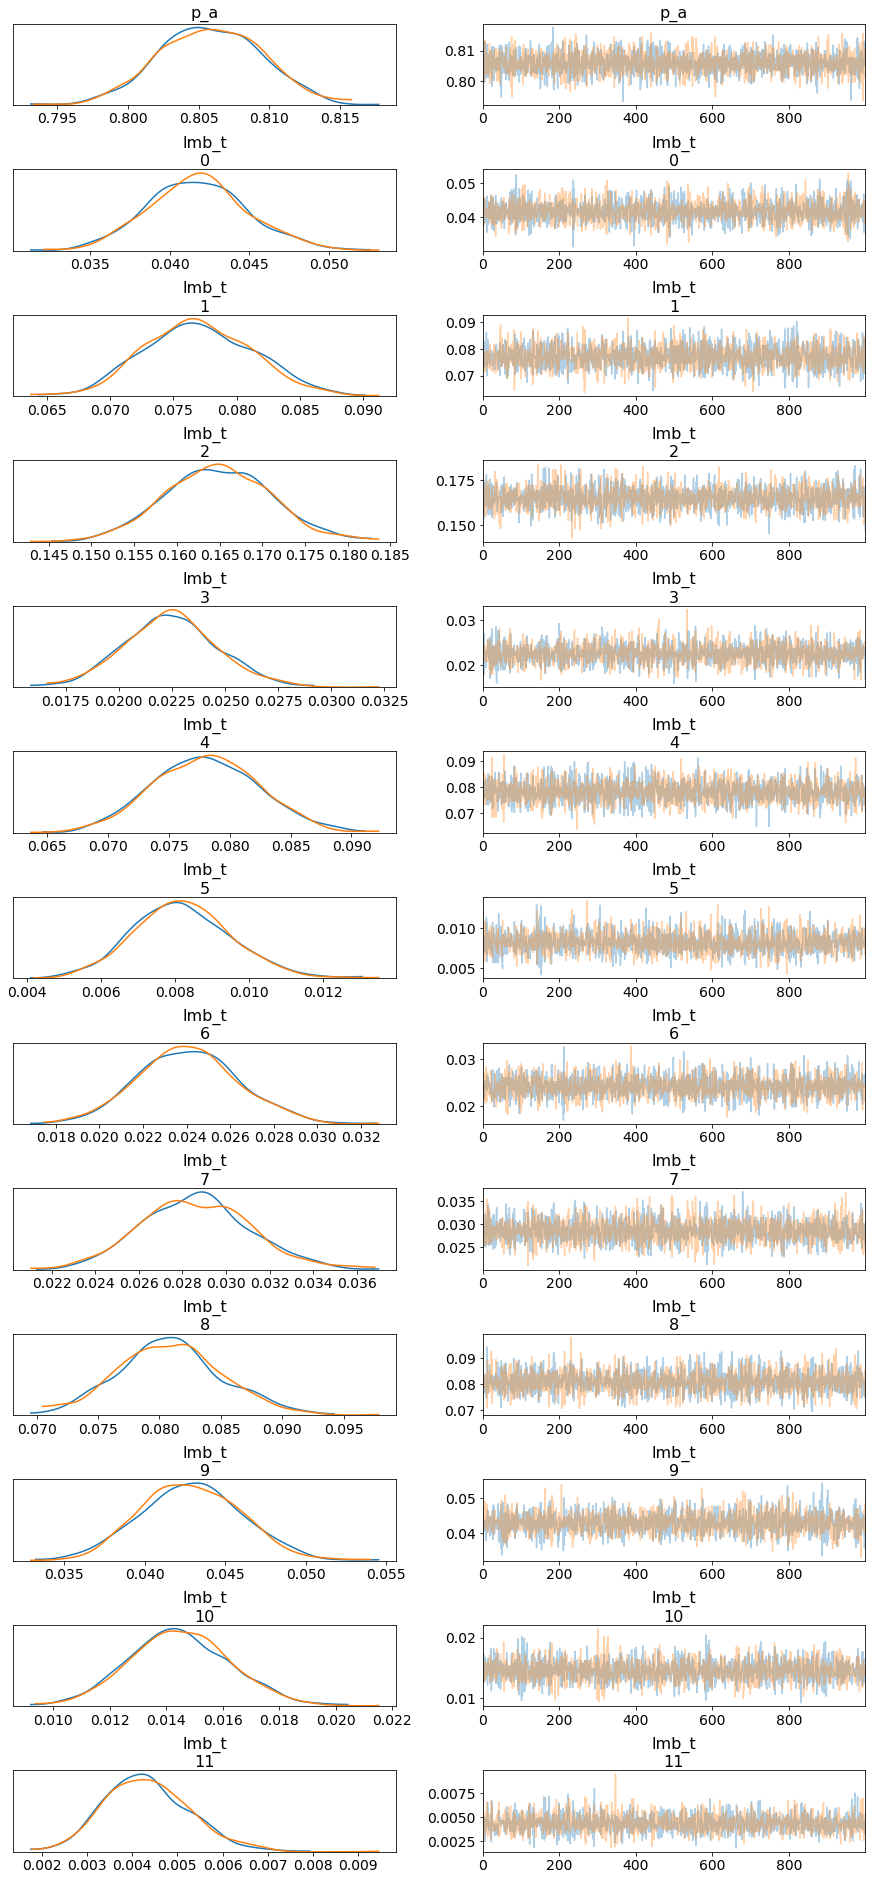

In [9]:
pm.traceplot(trace,varnames=['p_a','lmb_t']);

boxplot for Ut
ppc for x data sets
function of p_A and N
startified N 
